# Tanzania Water Well Classification

## Table of Contents

> #### 1. [Business Understanding](#Business-Understanding)
> #### 2. [Data Understanding](#Data-Understanding)
> #### 3. [Data Preparation](#Data-Preparation)
> #### 4. [Modeling](#Modeling)
> #### 5. [Evaluation](#Evaluation)
> #### 6. [Conclusions](#Conclusions)
> #### 7. [Resources](#Resources)

## 1. <a name ="Business-Understanding"></a> Business Understanding

### Background 

The country of Tanzania is struggling to provide safe, clean water to its more than 67 million citizens. A non-governmental organization (NGO) is assisting the Tanzanian government in addressing this critical issue by repairing damaged water wells. With over 70k water wells scattered across an area larger than twice the size of California, testing every single well is both costly and time-consuming.

Water from these wells is not only vital for drinking but also essential for cooking, sanitation, and hygiene practices. Ensuring access to clean water significantly impacts the health and livelihoods of the community. Therefore, the NGO requires an efficient method to identify which water wells need repair, streamlining their efforts to provide safe, clean water for all Tanzanians.

### Business Goals

The primary focus of this machine learning project is to assist the NGO in identifying all water wells requiring repair, enabling timely interventions to ensure safe, clean water for Tanzanians. The project aims to accurately identify every positive case (water well in need of repair) while minimizing false negatives, which occur when a well is incorrectly classified as functioning properly when, in reality, it is in need of repair.

Although some functional wells may be incorrectly classified as needing repair, the prevention of potential health hazards is of utmost importance. Therefore, the model prioritizes identifying wells that need repair, erring on the side of caution to ensure the safety of citizens who rely on these essential water sources.

### Business Success Criteria

The success of this project will be measured primarily by the model’s ability to classify wells in need of repair. The key metric associated with this ability is called recall, which addresses the question: 

> _“Out of all the wells that actually need repair, what percentage did our model correctly identify as needing repair?”_ 

Recall is calculated by dividing the number of true positives (the number of wells that genuinely require repair) by the combined total of true positives and false negatives (the wells that require repair but were incorrectly labeled as functional). 

$$
\text{Recall} = \frac {\text{True  Positives}}{\text{True  Positives + False  Negatives}}
$$

## 2. <a name ="Data-Understanding"></a> Data Understanding

The data for this project can be found here: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/. This data was collected by Taarifa and the Tanzanian Ministry of Water. 

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import train_test_split, cross_val_score

# classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [2]:
# reading csv files for training data and labels

y_train = pd.read_csv('./data/training_set_labels.csv')
training_features = pd.read_csv('./data/training_set_values.csv')
test_data = pd.read_csv('./data/test_set_values.csv')

In [3]:
training_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
y_train.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
training_data = training_features.merge(y_train, how = 'inner', on = 'id')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
training_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [9]:
training_data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


This output shows the summary statistics for the numeric columns. From this output, we can see that gps_height and population appear to be right skewed due to the fact that the mean is significantly larger than the median. This indicates the probable presence of outliers. 

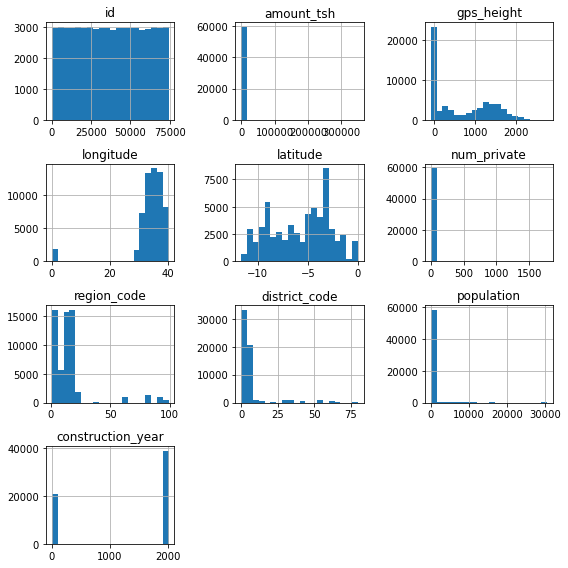

In [29]:
training_data.hist(bins = 20, figsize = (8,8))
plt.tight_layout();

In [11]:
# getting the percentage of null values in each feature

round((training_data.isna().sum()*100)/len(training_data), 2)

id                        0.00
amount_tsh                0.00
date_recorded             0.00
funder                    6.12
gps_height                0.00
installer                 6.15
longitude                 0.00
latitude                  0.00
wpt_name                  0.00
num_private               0.00
basin                     0.00
subvillage                0.62
region                    0.00
region_code               0.00
district_code             0.00
lga                       0.00
ward                      0.00
population                0.00
public_meeting            5.61
recorded_by               0.00
scheme_management         6.53
scheme_name              47.42
permit                    5.14
construction_year         0.00
extraction_type           0.00
extraction_type_group     0.00
extraction_type_class     0.00
management                0.00
management_group          0.00
payment                   0.00
payment_type              0.00
water_quality             0.00
quality_

This outputs the percentage of data within each feature that is null values. From this, we see that funder, installer, subvillage, public_meeting, scheme_management, permit all have only a small percentage of missing values. scheme_name at almost 50% is the only feature with a percentage of null values above 10%. This feature will be a focus during the data preprocessing phase.  

In [12]:
# defining a function to assist with cardinality assessment of each feature
# this function prints the value counts for each feature in the given dataset

def multiple_value_counts(dataframe,list_of_columns):
    for col in list_of_columns:
        print("----" + col + "----")
        print()
        print(dataframe[col].value_counts())
        print()

In [13]:
multiple_value_counts(training_data, training_data.columns)

----id----

2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64

----amount_tsh----

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

----date_recorded----

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2012-01-21      1
2011-09-05      1
2004-03-06      1
2011-09-11      1
2011-09-21      1
Name: date_recorded, Length: 356, dtype: int64

----funder----

Government Of Tanzania           9084
Danida                           3114
Hesawa                           2202
Rwssp                            1374
World Bank                       1349
                                 ... 
Serikaru                            1
Sisal Estste Ha

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

----water_quality----

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

----quality_group----

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

----quantity----

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

----quantity_group----

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

----source----

spring                  17021
shal

In [14]:
training_data.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

The above output gives the value counts and number of unique entries for each feature in the training data. This helps understand the cardinality of each feature. Features with high cardinality, such as wpt_name (37400 unique entries) and subvillage (19287 unique entries), may not be helpful in this classification. Thus, these features will be an area of focus during the data preparation phase. 

In [15]:
# examining the entries of wells with longitude = 0
training_data[training_data['longitude'] == 0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,0,DWE,0.0,-2.000000e-08,Wazazo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Mtakuja,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,0,DWE,0.0,-2.000000e-08,Maendeleo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.0,-2.000000e-08,Mwazwilo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [16]:
# examining the latitudes of wells with longitude = 0
training_data[training_data['longitude'] == 0].latitude.value_counts()

-2.000000e-08    1812
Name: latitude, dtype: int64

In [17]:
# examining the amount_tsh of wells with longitude = 0
training_data[training_data['longitude'] == 0].amount_tsh.value_counts()

0.0    1812
Name: amount_tsh, dtype: int64

### Data Observations

Several features give the same info:
- scheme_name or scheme_management… probably scheme_name
- Extraction_type, extraction_type_group, extraction_type_class
- Management, management_group
- Payment, payment_type
- Water_quality, quality_group
- Quantity, quantity_group
- Source, source_type, source_class
- Waterpoint_type, waterpoint_type_group
- Geographic location:
 - Subvillage
 - Region
 - Region_code
 - District_code
 - Lga
 - ward


Other categories to consider dropping:
- Num_private
- Public_meeting… what does this mean? 
- Wtp_name… is this important if we already have the id?
- Amount_tsh
- Date_recorded

Investigate further:
- Construction year entries with year 0… what’s going on there??
- longitude = 0 & latitude = -2.0e-8

#### Class Distribution

In [18]:
# Gives the class distribution for the target
training_data.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

The output above shows that the target has three classes. For practicality, I will turn this into a binary classification problem

In [19]:
# Gives the class distribution for the target as a percentage

round(training_data.status_group.value_counts(normalize = True), 2) * 100

functional                 54.0
non functional             38.0
functional needs repair     7.0
Name: status_group, dtype: float64

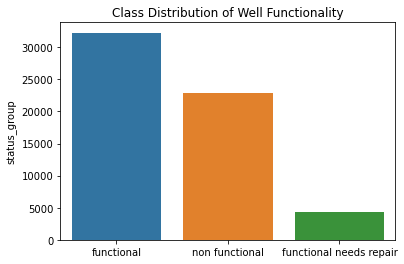

In [20]:
# Barplot of the class distribution
sns.barplot(x = training_data.status_group.value_counts().index,
            y = training_data.status_group.value_counts(), 
).set_title('Class Distribution of Well Functionality');

In [21]:
# grouping classes into two groups for binary classification: Needs repair and Repair Not Needed
training_data.status_group.replace({'functional' : 'Repair Not Needed', 'non functional' : 'Needs Repair', 'functional needs repair' : 'Needs Repair'}, inplace = True)

In [22]:
# Gives the class distribution for the target
training_data.status_group.value_counts()

Repair Not Needed    32259
Needs Repair         27141
Name: status_group, dtype: int64

In [23]:
# Gives the class distribution for the target as a percentage

round(training_data.status_group.value_counts(normalize = True), 2) * 100

Repair Not Needed    54.0
Needs Repair         46.0
Name: status_group, dtype: float64

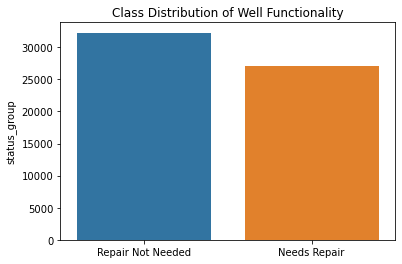

In [24]:
# Barplot of the class distribution
sns.barplot(x = training_data.status_group.value_counts().index,
            y = training_data.status_group.value_counts()
).set_title('Class Distribution of Well Functionality');

#### Inspecting Test Data

In [ ]:
print(test_data.shape)

In [ ]:
test_data.info()

## 3. <a name ="Data-Preparation"></a> Data Preparation

## 4. <a name ="Modeling"></a> Modeling

## 5. <a name ="Evaluation"></a> Evaluation

## 6. <a name ="Conclusions"></a> Conclusions

### Limitations

### Recommendations

### Next Steps

## 7. <a name ="Resources"></a> Resources

This project idea and data came from:

DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

Used this to create bold font in multiple_value_counts function in order to highlight the number of unique values in each feature to help with cardinality analysis of each feature
https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python

Use this:

print '\033[1m' + 'Hello'

And to change back to normal:

print '\033[0m'